# SimCLr contrastive Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/jupyter/ML_for_slideseq")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier.util_data import *

/opt/conda/lib/python3.7/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.12. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.13
  warnings.warn(Warning(warning))


### Create 6 dataframes (3 sick, 3 healthy) with x,y, and celltype information

In [4]:
#root = "/Users/ldalessi/REPOS/ML_for_slideseq/data/" 
#
#wt1_xy = root+ "WT/WT1/BeadLocationsForR_T3_Trimmed.csv"
#wt1_celltype = root + "WT/WT1/PuckT3_bead_maxct_df.csv"
#df_wt1 = pd.read_csv(wt1_xy, 
#                     usecols=["barcode","x","y"]).merge(pd.read_csv(wt1_celltype, 
#                                                                    usecols=["barcode","max_cell_type"]))
#                                                         
#wt2_xy = root + "WT/WT2/BeadLocationsForR_Puck24_Trimmed_cleaned.csv"
#wt2_celltype = root + "/WT/WT2/Puck24_bead_maxct_df.csv"
#df_wt2 = pd.read_csv(wt2_xy, 
#                     usecols=["barcode","x","y"]).merge(pd.read_csv(wt2_celltype, 
#                                                                    usecols=["barcode","max_cell_type"]))
#                                                         
#wt3_xy = root + "WT/WT3/BeadLocationsForR_Normal_Puck7_Trimmed.csv"
#wt3_celltype = root + "WT/WT3/Normal_Puck7_bead_maxct_df.csv"
#df_wt3 = pd.read_csv(wt3_xy, 
#                     usecols=["barcode","x","y"]).merge(pd.read_csv(wt3_celltype, 
#                                                                    usecols=["barcode","max_cell_type"]))
#                                                         
#
#dis1_xy = root + "DIABETES/Diabetes_1/BeadLocationsForR_T4_Trimmed.csv"
#dis1_celltype = root + "DIABETES/Diabetes_1/Puck_T4_bead_maxct_df.csv"
#df_dis1 = pd.read_csv(dis1_xy, 
#                      usecols=["barcode","x","y"]).merge(pd.read_csv(dis1_celltype, 
#                                                                     usecols=["barcode","max_cell_type"]))
#
#dis2_xy = root + "/DIABETES/Diabetes_2/BeadLocationsForR_Diabetes_Puck10_Trimmed.csv"
#dis2_celltype = root + "DIABETES/Diabetes_2/Diabetes_Puck10_bead_maxct_df.csv"
#df_dis2 = pd.read_csv(dis2_xy, 
#                      usecols=["barcode","x","y"]).merge(pd.read_csv(dis2_celltype, 
#                                                                     usecols=["barcode","max_cell_type"]))
#
#dis3_xy = root + "DIABETES/Diabetes_3/BeadLocationsForR_Diabetes_Puck11_Trimmed.csv"
#dis3_celltype = root + "DIABETES/Diabetes_3/Diabetes_Puck11_bead_maxct_df.csv"
#df_dis3 = pd.read_csv(dis3_xy, 
#                      usecols=["barcode","x","y"]).merge(pd.read_csv(dis3_celltype, 
#                                                                     usecols=["barcode","max_cell_type"]))

In [5]:
## Save the 6 dataframes to file
#df_wt1.to_csv(root + "wt1.csv", index=False)
#df_wt2.to_csv(root + "wt2.csv", index=False)
#df_wt3.to_csv(root + "wt3.csv", index=False)
#df_dis1.to_csv(root + "dis1.csv", index=False)
#df_dis2.to_csv(root + "dis2.csv", index=False)
#df_dis3.to_csv(root + "dis3.csv", index=False)

In [4]:
root = "/home/jupyter/data/slide-seq/original_data/"

df_wt1 = pd.read_csv(root + "wt_1.csv")
df_wt2 = pd.read_csv(root + "wt_2.csv")
df_wt3 = pd.read_csv(root + "wt_3.csv")
df_dis1 = pd.read_csv(root + "sick_1.csv")
df_dis2 = pd.read_csv(root + "sick_2.csv")
df_dis3 = pd.read_csv(root + "sick_3.csv")

# Define the defaults

In [5]:
num_workers = 8
batch_size = 128
seed = 1
max_epochs = 100
input_size = 224
num_ftrs = 32
pixel_size = 4.0
crop_size = input_size
input_channels = 9
n_element_min = 200

# Load all sparse images and labels

In [6]:
# all_df = [df_wt1, df_wt2, df_wt3, df_dis1, df_dis2, df_dis3]
all_df = [df_wt1, df_wt2, df_dis1, df_dis2]
# labels_sparse_images = ["wt1", "wt2", "wt3", "dis1", "dis2", "dis3"]
labels_sparse_images = ["wt1", "wt2", "dis1", "dis2"]
sparse_images = [
    SparseImage.from_panda(
    df, x="x", y="y", category="cell_type", 
    pixel_size=pixel_size, padding=10) for df in all_df
]

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 1168, 1168])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 1170, 845])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 1166, 1170])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 1170, 1170])


### Testdataset

In [9]:
n_crops_test = 50

testdata_transform = torchvision.transforms.Compose([
    StackTensor(dim=-4),
    RandomGaussianBlur(sigma=(1.0, 5.0)),
    torchvision.transforms.Resize(input_size)
])

testdataset = SparseDataset(x=RandomCropSparseTensor(n_crops=n_crops_test, 
                                                     crop_size=crop_size,
                                                     n_element_min=n_element_min)(sparse_images), 
                            y=Interleave(n_repeat=n_crops_test)(labels_sparse_images))

dataloader_test = DataLoaderWithLoad(
    testdataset,
    batch_size=batch_size,
    collate_fn=SpecialCollateFn(transform=testdata_transform, simclr_output=False),
    shuffle=False)

{}


torch.Size([128, 9, 224, 224]) torch.Size([128]) 128


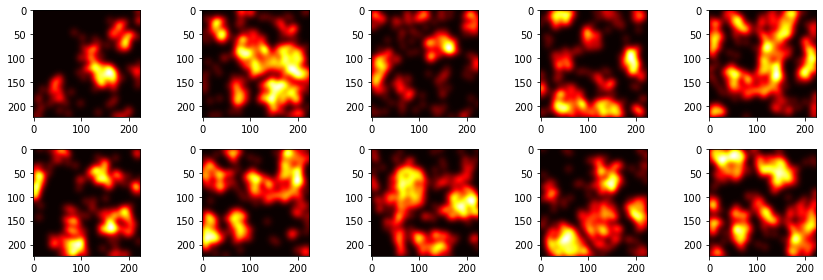

In [10]:
imgs, labels, fname = next(iter(dataloader_test))
print(imgs.shape, labels.shape, len(fname))
show_tensor(imgs[:10, 0], figsize=(12,4), n_col=5, cmap='hot', normalize_range=(0.0, 1.0))

### Traindataset

In [97]:
n_crops_for_tissue = int(numpy.ceil(float(batch_size) / len(sparse_images)))

sparse_dataset_train = SparseDataset(x=sparse_images, 
                                     y=labels_sparse_images,
                                     transform_x=RandomCropSparseTensor(n_crops=n_crops_for_tissue, 
                                                                        crop_size=int(1.5*crop_size),
                                                                        n_element_min=100),
                                     transform_y=Interleave(n_repeat=n_crops_for_tissue)) 

train_transform = torchvision.transforms.Compose([
    DropoutSparseTensor(dropout=(0.0, 0.4)),
    StackTensor(dim=-4),
    torchvision.transforms.RandomAffine(
        degrees=180, 
        scale=(0.75, 1.25), 
        shear=0.0, 
        interpolation=torchvision.transforms.InterpolationMode.NEAREST, 
        fill=0
    ),
    RandomIntensity(factor=(0.7, 1.3)),
    torchvision.transforms.CenterCrop(size=crop_size),
    torchvision.transforms.Resize(input_size),
    RandomDiagonalCut(p=0.85),
    RandomGaussianBlur(sigma=(1.0, 2.0)),
])

   
dataloader_train = DataLoaderWithLoad(
    sparse_dataset_train,
    batch_size=sparse_dataset_train.__len__(),
    collate_fn=SpecialCollateFn(transform=train_transform, simclr_output=True),
    shuffle=False)

{}
{}
{}
{}
I AM HERE
torch.Size([128, 9, 224, 224])
I AM HERE
torch.Size([128, 9, 224, 224])
torch.Size([128, 9, 224, 224]) torch.Size([128, 9, 224, 224]) torch.Size([128])


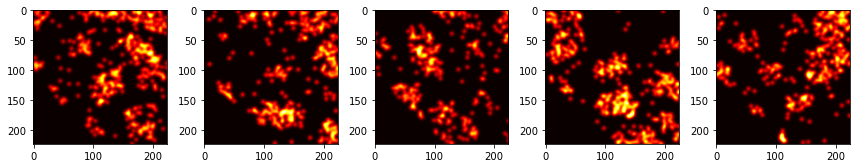

In [98]:
(imgs0, imgs1), labels, list_filenames = next(iter(dataloader_train))
print(imgs0.shape, imgs1.shape, labels.shape)
show_tensor(imgs0[:5, 0], figsize=(12,4), n_col=10, cmap='hot', normalize=False)

{}
{}
{}
{}
I AM HERE
torch.Size([128, 9, 224, 224])
torch.Size([128, 9, 224, 224]) torch.Size([128, 9, 224, 224]) torch.Size([128])


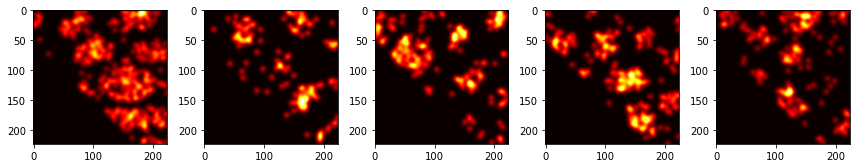

In [99]:
(imgs0, imgs1), labels, list_filenames = next(iter(dataloader_train))
print(imgs0.shape, imgs1.shape, labels.shape)
show_tensor(imgs0[:5, 0], figsize=(12,4), n_col=10, cmap='hot', normalize=False)

{}
{}
{}
{}
I AM HERE
torch.Size([128, 9, 224, 224])
I AM HERE
torch.Size([128, 9, 224, 224])
torch.Size([128, 9, 224, 224]) torch.Size([128, 9, 224, 224]) torch.Size([128])


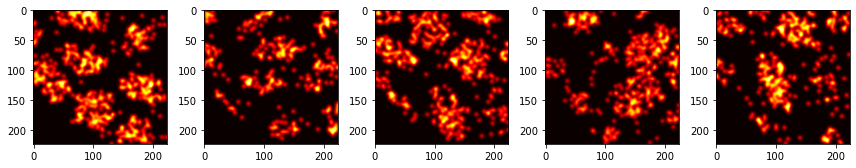

In [100]:
(imgs0, imgs1), labels, list_filenames = next(iter(dataloader_train))
print(imgs0.shape, imgs1.shape, labels.shape)
show_tensor(imgs0[:5, 0], figsize=(12,4), n_col=10, cmap='hot', normalize=False)

{}
{}
{}
{}
I AM HERE
torch.Size([128, 9, 224, 224])
I AM HERE
torch.Size([128, 9, 224, 224])
torch.Size([128, 9, 224, 224]) torch.Size([128, 9, 224, 224]) torch.Size([128])


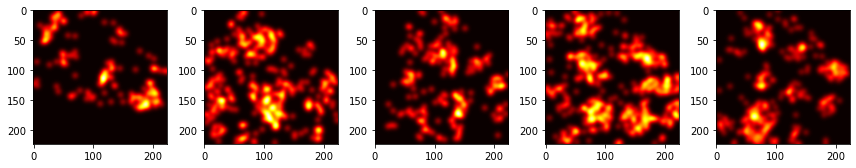

In [101]:
(imgs0, imgs1), labels, list_filenames = next(iter(dataloader_train))
print(imgs0.shape, imgs1.shape, labels.shape)
show_tensor(imgs0[:5, 0], figsize=(12,4), n_col=10, cmap='hot', normalize=False)

{}
{}
{}
{}
I AM HERE
torch.Size([128, 9, 224, 224])
I AM HERE
torch.Size([128, 9, 224, 224])
torch.Size([128, 9, 224, 224]) torch.Size([128, 9, 224, 224]) torch.Size([128])


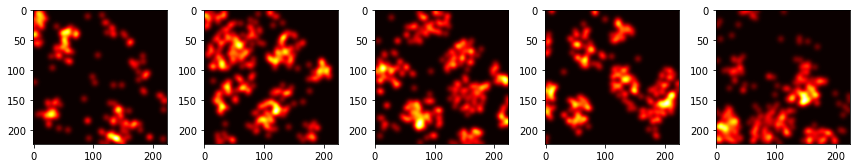

In [102]:
(imgs0, imgs1), labels, list_filenames = next(iter(dataloader_train))
print(imgs0.shape, imgs1.shape, labels.shape)
show_tensor(imgs0[:5, 0], figsize=(12,4), n_col=10, cmap='hot', normalize=False)

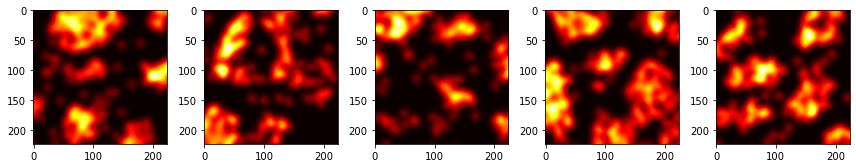

In [41]:
show_tensor(imgs1[:5, 0], figsize=(12,4), n_col=10, cmap='hot', normalize=False)

# Create the SimClr model

In [14]:
pl.seed_everything(seed)

Global seed set to 1


1

In [15]:
resnet = torchvision.models.resnet18()
last_conv_channels = list(resnet.children())[-1].in_features
first_conv_out_channels = list(resnet.children())[0].out_channels
backbone = torch.nn.Sequential(
    torch.nn.Conv2d(input_channels, first_conv_out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    *list(resnet.children())[1:-1],
    torch.nn.Conv2d(last_conv_channels, num_ftrs, 1),
)

# create the SimCLR model using the newly created backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

In [26]:
criterion = lightly.loss.NTXentLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_train
)

In [27]:
gpus = 1 if torch.cuda.is_available() else 0

In [28]:
from pytorch_lightning.loggers import NeptuneLogger

In [29]:
neptune_logger = NeptuneLogger(
    api_key='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjNhOTY3ZS1mOGU2LTQ2ZGItYTFmOS01MGY4ZDdiNGU1YTcifQ==',
    project_name='fedorgrab/slide-seq-contrastive',
    experiment_name='Test Neptune Logger Lightly',  # Optional,
#     params={'max_epochs': 10},  # Optional,
    tags=['pytorch-lightning', 'contrastive']  # Optional,
)

NeptuneLogger will work in online mode


In [ ]:
encoder.train_embedding(
    gpus=gpus,
    progress_bar_refresh_rate=1,
    max_epochs=10 * max_epochs,
    logger=neptune_logger,
    log_every_n_steps=1
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | SimCLR     | 11.2 M
1 | criterion | NTXentLoss | 0     
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.868    Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

https://app.neptune.ai/fedorgrab/slide-seq-contrastive/e/SDCL-1


In [22]:
pretrained_resnet_backbone = model.backbone

# you can also store the backbone and use it in another code
state_dict = {
    'resnet18_parameters': pretrained_resnet_backbone.state_dict()
}
torch.save(state_dict, 'model.pth')

# Visualize the embeddings 

In [23]:
device = 'cuda' if gpus==1 else 'cpu'
encoder = encoder.to(device)

embeddings, labels, fnames = encoder.embed(dataloader_test, device=device, to_numpy=True)
embeddings = normalize(embeddings)

Compute efficiency: 0.01: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


In [1]:
def plot_knn_examples(embeddings, dataloader: DataLoaderWithLoad, n_neighbors=3, num_examples=6, figsize=(6,6)):
    """
    Select some random examples and show the their nearest neighbors
    """
    
    # For each sample get n_neighbours indices and distances 
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    nbrs_distances, nbrs_indices = nbrs.kneighbors(embeddings)  # shape: len_dataset, n_neighbours
   
    # get some random samples
    samples_idx = numpy.random.choice(nbrs_indices.shape[0], size=num_examples, replace=False)
    
    # plot the randomly picked examples and their neighbours
    fig, ax = plt.subplots(ncols=n_neighbors, nrows=num_examples, figsize=figsize) 
    for r, idx in enumerate(samples_idx):
        indeces = list(nbrs_indices[idx])
        distances = list(nbrs_distances[idx])
        tensors, labels, fnames = dataloader.load(index=indeces)
        # print(tensors.shape) # n_neighbours, ch, w, h
        for c in range(n_neighbors):
            #img = tensors[c,0].cpu().numpy() # plot just the first 3 channels
            img = tensors[c,:3].permute(1,2,0).cpu().numpy() # plot just the first 3 channels
            img = (img - numpy.min(img))/(numpy.max(img)-numpy.min(img))
            ax[r,c].imshow(img)  
            ax[r,c].set_title(f'd={distances[c]:.3f}')
            ax[r,c].set_axis_off()
    plt.close(fig)
    return fig 

NameError: name 'DataLoaderWithLoad' is not defined

In [25]:
img = plot_knn_examples(embeddings, dataloader_test, n_neighbors=10, num_examples=30, figsize=(20,80))

In [26]:
img.savefig("./aaa.png")

# TODO

In [ ]:
def tiling(sparse_images, trained_model, transform):
    raise NotImplementedError
    
    
